<h2> Explore Data </h2>

In [ ]:
class Config:
    epoch = 20
    lr = 1e-4
    batch_size = 64
    window = 15       # data dimension -> (n_sample, window * 250, channel) window is in seconds
    shift = 10         # overlapping seconds while creating data for training. start = start + shift
    channel = 2       #select channel 0 for Lead I, channel 1 for Lead II, channel 2 for both Lead while training.
    threshold = 0.5
    run = 1

In [3]:
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from typing import List, Tuple

In [3]:
import os
path = "/mnt/storage2/arafat_shovon/deep_learning_project/physionet.org/files/afdb/1.0.0/"
# path = "D:/notebook/Deep Learning Course/files/"

In [4]:
files = os.listdir(path)
print(len(files))

133


In [5]:
files = [file.split('.')[0] for file in files]
remove_list = ['old', 'index', 'RECORDS', 'ANNOTATORS', 'SHA256SUMS', 'notes', '00735', '03665']

# Remove all occurrences (in case of duplicates)
files = [f for f in files if f not in remove_list]
files = list(set(files))
print(files)

['04043', '07859', '08215', '04746', '08405', '05261', '04908', '06995', '04015', '08378', '07879', '07910', '08434', '04048', '04936', '05121', '08455', '04126', '06426', '05091', '06453', '08219', '07162']


In [6]:
record_name = os.path.join(path, files[10])
record = wfdb.rdheader(record_name)
print(f"Record: {record.record_name}")
print(f"Sampling frequency: {record.fs} Hz")
print(f"Signal length: {record.sig_len} samples")
print(f"Duration: {record.sig_len/record.fs:.2f} seconds")

Record: 07879
Sampling frequency: 250 Hz
Signal length: 9205760 samples
Duration: 36823.04 seconds


In [7]:
annotations = wfdb.rdann(record_name, 'atr')
print(f"Number of annotations: {len(annotations.sample)}")
print(f"Episodes : {annotations.aux_note}")
print(f"annotation symbols : {annotations.symbol}")
print(f"annotation sample : {annotations.sample}")

Number of annotations: 5
Episodes : ['(N', '(AFIB', '(J', '(AFIB', '(N']
annotation symbols : ['+', '+', '+', '+', '+']
annotation sample : [     54 1783080 7333067 7334783 7335468]


In [7]:
channels = []
rhythms = []
for file in files:
    record_name = os.path.join(path, file)
    ann = wfdb.rdann(record_name, 'atr')
    qrs = wfdb.rdann(record_name, 'qrs')
    rhythms.append(np.unique(qrs.symbol))
    channels.append(np.unique(ann.chan))
print(rhythms)
print(channels)

[array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1')]
[array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0])]


In [8]:
symbol = []
for file in files:
    record_name = os.path.join(path, file)
    ann = wfdb.rdann(record_name, 'atr')
    symbol.append(set(ann.symbol))
print(symbol)

[{'+'}, {'+'}, {'+'}, {'+'}, {'+'}, {'+'}, {'+'}, {'+'}, {'+'}, {'+'}, {'+'}, {'+'}, {'+'}, {'+'}, {'+'}, {'+'}, {'+'}, {'+'}, {'+'}, {'+'}, {'+'}, {'+'}, {'+'}, {'+'}, {'+'}]


In [9]:
shortest_interval =[]
for file in files:
    record_name = os.path.join(path, file)
    ann = wfdb.rdann(record_name, 'atr')
    if ann.sample.shape[0] > 1:
        shortest_interval.append(np.min(ann.sample[1:]-ann.sample[:-1]))
print(shortest_interval)

[np.int64(2226), np.int64(624), np.int64(6076), np.int64(1174), np.int64(1545), np.int64(433), np.int64(2062), np.int64(4387), np.int64(1530), np.int64(848), np.int64(685), np.int64(1695), np.int64(4403), np.int64(1700), np.int64(12347), np.int64(381), np.int64(4269), np.int64(421), np.int64(883), np.int64(66017), np.int64(12560), np.int64(1239), np.int64(626)]


In [8]:
def check_for_multiple_boundary(index, sample, end):
    mul_bound = False
    next_index = index
    # if index+1 < len(sample):
    for idx in range(index, len(sample)):
        if end >= sample[idx]:
            next_index = idx
            mul_bound = True
    return mul_bound, next_index


def create_training_data(path:str, file_name:str, window:int, shift:int):
    record_name = os.path.join(path, file_name)
    signal = wfdb.rdrecord(record_name)
    ann = wfdb.rdann(record_name, 'atr')
    boundary_idx = 0
    start, next_boundary = ann.sample[boundary_idx], ann.sample[boundary_idx]
    region = ann.aux_note[boundary_idx]
    data = []
    label = []
    while start+window < signal.p_signal.shape[0]:
        data.append(signal.p_signal[start:start+window,:])
        if not start < next_boundary < start + window:
            label.append(0) if region == '(N' else label.append(1)
        else:
            percent = (next_boundary - start)/window * 100
            mul_bound, _ = check_for_multiple_boundary(boundary_idx+1, ann.sample, start+window)
            if mul_bound:
                data.pop()
            elif percent > 50:
                label.append(0) if region == '(N' else label.append(1)
            else:
                label.append(1) if region == '(N' else label.append(0)

        start += shift
        mul_bound, boundary_idx = check_for_multiple_boundary(boundary_idx, ann.sample, start)
        if mul_bound:
            region = ann.aux_note[boundary_idx]
            if boundary_idx + 1 < len(ann.sample):
                boundary_idx += 1
        next_boundary = ann.sample[boundary_idx]
            
    return np.array(data), np.array(label)


In [9]:
index = 0
record_name = os.path.join(path, files[index])
print(record_name)
ann = wfdb.rdann(record_name, 'atr')
record = wfdb.rdrecord(record_name)
diff = ann.sample[1:] - ann.sample[:-1]
diff = diff.tolist()
diff.append(int(record.p_signal.shape[0] - ann.sample[-1]))
for x, y, z in zip(ann.sample, ann.aux_note, diff):
    print(f"{y} - {int(x)} : length : {z}")
print(f"total length: {len(ann.sample)}")

/mnt/storage2/arafat_shovon/deep_learning_project/physionet.org/files/afdb/1.0.0/04043
(N - 68 : length : 266430
(AFIB - 266498 : length : 109830
(N - 376328 : length : 2208956
(AFIB - 2585284 : length : 17232
(N - 2602516 : length : 32395
(AFIB - 2634911 : length : 104901
(N - 2739812 : length : 5350
(AFIB - 2745162 : length : 34419
(N - 2779581 : length : 55158
(AFIB - 2834739 : length : 6989
(N - 2841728 : length : 277507
(AFIB - 3119235 : length : 2471
(N - 3121706 : length : 202820
(AFIB - 3324526 : length : 27657
(N - 3352183 : length : 254941
(AFIB - 3607124 : length : 30395
(N - 3637519 : length : 28105
(AFIB - 3665624 : length : 15006
(N - 3680630 : length : 9726
(AFIB - 3690356 : length : 16676
(N - 3707032 : length : 7423
(AFIB - 3714455 : length : 14999
(N - 3729454 : length : 28439
(AFIB - 3757893 : length : 92280
(N - 3850173 : length : 14165
(AFIB - 3864338 : length : 17748
(N - 3882086 : length : 29879
(AFIB - 3911965 : length : 27764
(N - 3939729 : length : 7619
(AFIB 

In [10]:
window_time, shift_time = 15, 10
def show_total_sample(record_name):
    ann = wfdb.rdann(record_name, 'atr')
    record = wfdb.rdrecord(record_name)
    diff = ann.sample[1:] - ann.sample[:-1]
    diff = diff.tolist()
    diff.append(int(record.p_signal.shape[0] - ann.sample[-1]))
    count_dict = {
        'AF':0,
        'N':0
    }
    for index, sym in enumerate(ann.aux_note):
        if sym  == '(N':
            count_dict['N'] += diff[index]
        else:
            count_dict['AF'] += diff[index]
    print(count_dict)
    print(f"expected Normal : {count_dict['N'] / (window_time*250)}")
    print(f"expected AF : {count_dict['AF'] / (window_time*250)}")
show_total_sample(record_name)


{'AF': 1983151, 'N': 7222541}
expected Normal : 1926.0109333333332
expected AF : 528.8402666666667


In [11]:

x, y = create_training_data(path, files[index], window_time*250, shift_time*250)
print(x.shape, y.shape)
df = pd.DataFrame(y, columns=['label'])
print(df.label.value_counts())

(3680, 3750, 2) (3680,)
label
0    2884
1     796
Name: count, dtype: int64


In [53]:
ch1_cols = [f"feature_{id}" for id in range(x.shape[1])]
ch2_cols = [f"feature_{id}" for id in range(x.shape[1])]
ch1 = pd.DataFrame(x[:, :, 0], columns=ch1_cols)
ch2 = pd.DataFrame(x[:, :, 1], columns=ch2_cols)

ch1['label']=  y
ch2['label'] = y


# with pd.ExcelWriter("ecg_data.xlsx") as writer:
#     ch1.to_excel(writer, sheet_name="Channel_1", index=False)
#     ch2.to_excel(writer, sheet_name="Channel_2", index=False)

In [54]:
data = ch2.copy()
data['label'].value_counts()
normal = data[data['label'] == 0].iloc[:, :-1].values
af = data[data['label'] == 1].iloc[:, :-1].values

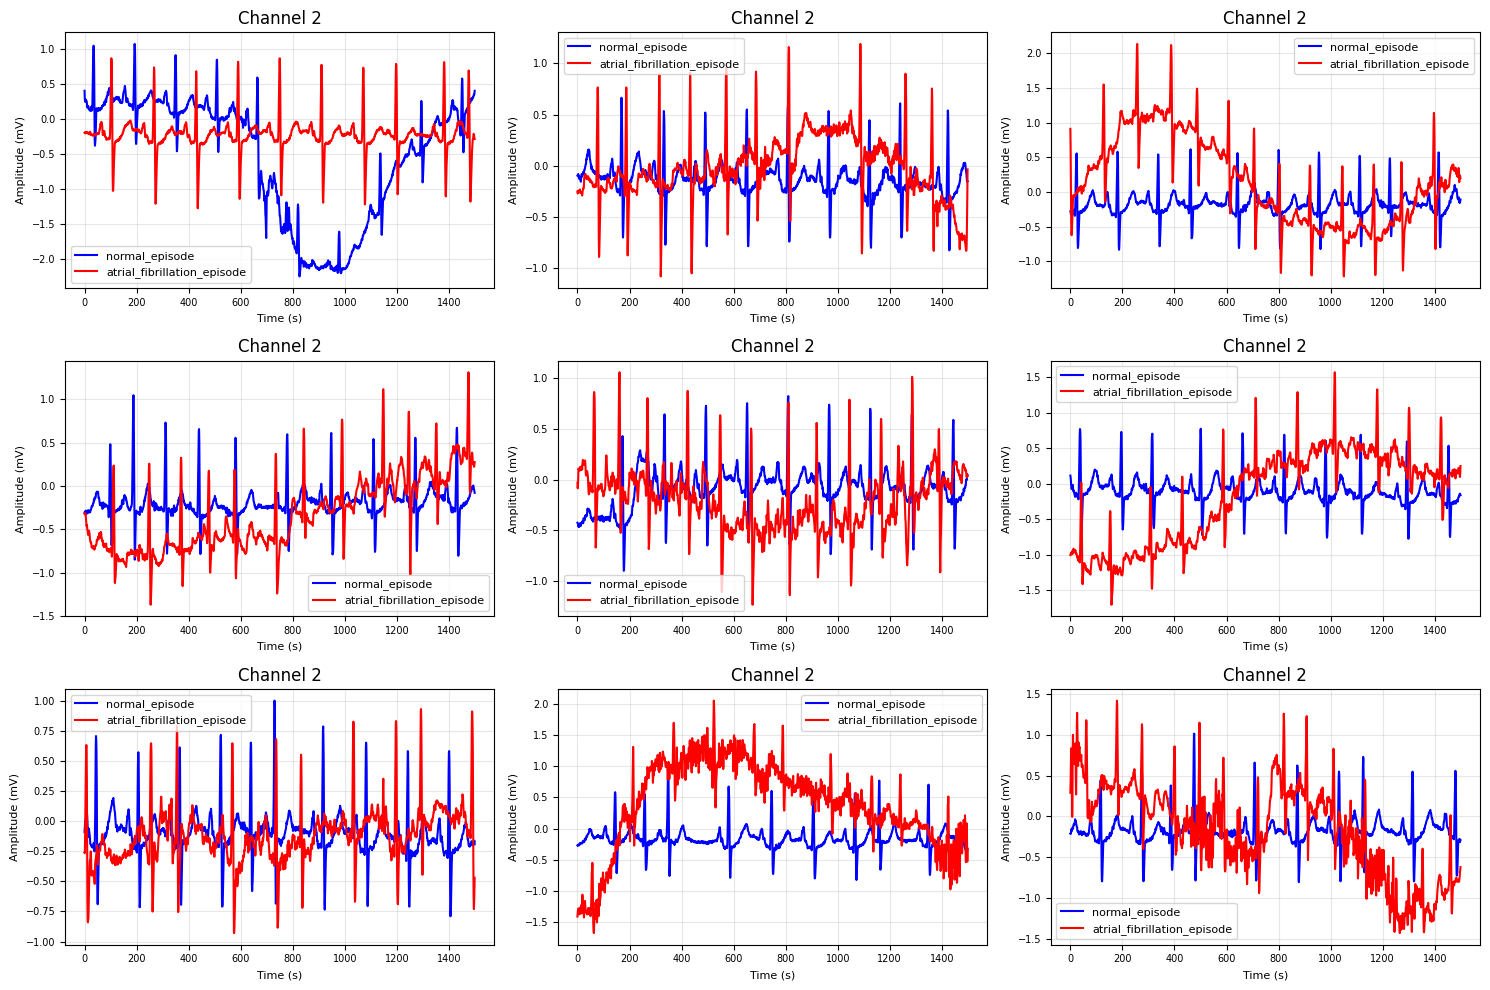

In [ ]:
# Create 3x3 subplot grid
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

fig_index = 200
length = 1500
time_start = 500
time_end = time_start + length if (time_start + length) < 2500 else 2500
for i in range(3):
    for j in range(3):
        axes[i, j].plot(normal[fig_index, time_start:time_end], 'b-', label='N_episode')
        axes[i, j].plot(af[fig_index, time_start:time_end], 'r-', label='AF_episode')
        axes[i, j].set_title(f'Channel 2')
        axes[i, j].grid(True)

        axes[i, j].set_xlabel('Time (s)', fontsize=8)
        axes[i, j].set_ylabel('Amplitude (mV)', fontsize=8)
        axes[i, j].grid(True, alpha=0.3)
        axes[i, j].legend(fontsize=8)
        axes[i, j].tick_params(labelsize=7)

        fig_index += 1

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

In [56]:
data = ch1.copy()
data['label'].value_counts()
normal = data[data['label'] == 0].iloc[:, :-1].values
af = data[data['label'] == 1].iloc[:, :-1].values

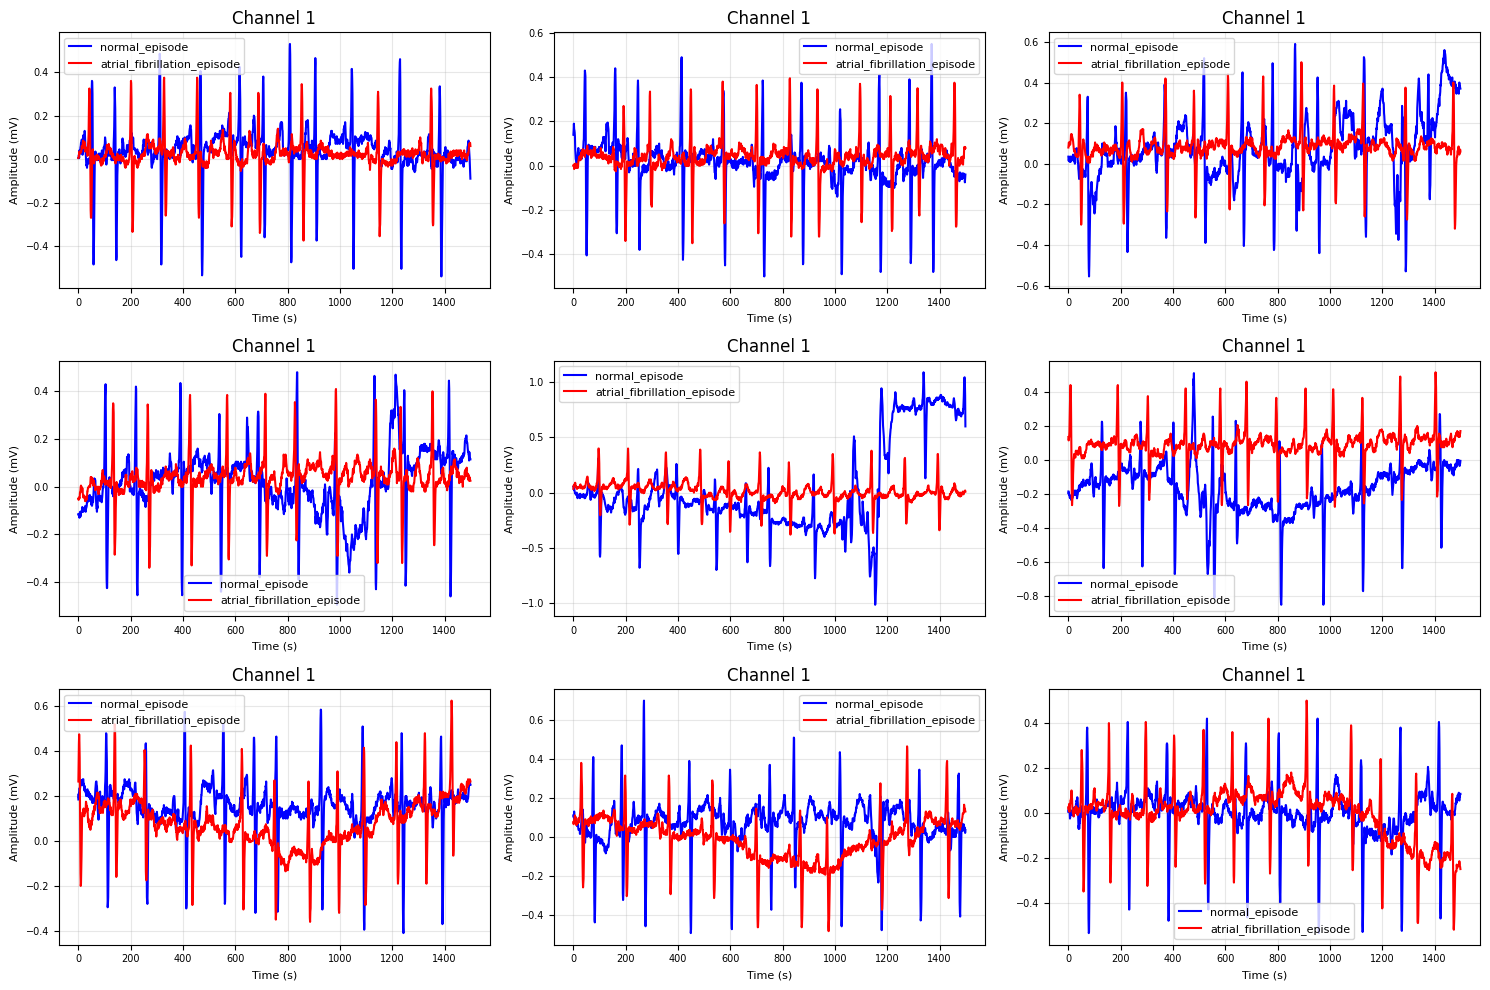

In [ ]:
# Create 3x3 subplot grid
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

fig_index = 300
length = 1500
time_start = 100
time_end = time_start + length if (time_start + length) < 2500 else 2500
for i in range(3):
    for j in range(3):
        axes[i, j].plot(normal[fig_index, time_start:time_end], 'b-', label='N_episode')
        axes[i, j].plot(af[fig_index, time_start:time_end], 'r-', label='AF_episode')
        axes[i, j].set_title(f'Channel 1')
        axes[i, j].grid(True)

        axes[i, j].set_xlabel('Time (s)', fontsize=8)
        axes[i, j].set_ylabel('Amplitude (mV)', fontsize=8)
        axes[i, j].grid(True, alpha=0.3)
        axes[i, j].legend(fontsize=8)
        axes[i, j].tick_params(labelsize=7)

        fig_index += 1

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

<h3> Digging into Data </h3>

In [ ]:
af_data = ch1[ch1['label'] == 1].iloc[:, 0:-1].values.flatten()
normal_data = ch1[ch1['label'] == 0].iloc[:, 0:-1].values.flatten()

<h4> Mean and Standard deviation </h4>

In [34]:
normal_mean, normal_std = np.mean(normal_data), np.std(normal_data)
af_mean, af_std = np.mean(af_data), np.std(af_data)
print(f"Normal Data, Mean : {normal_mean}, Std : {normal_std}")
print(f"AF Data, Mean : {af_mean}, Std : {af_std}")


Normal Data, Mean : 0.027954117891816923, Std : 0.19860638239220113
AF Data, Mean : 0.023921748222501045, Std : 0.1859450451268662


In [ ]:
from scipy.stats import ttest_ind
p_value = []
feature_cols = ch1.columns.drop(['label'])
for col in feature_cols:
    normal_val = ch1[ch1['label'] == 0][col]
    af_val = ch1[ch1['label'] == 1][col]
    stat, p = ttest_ind(normal_val, af_val, equal_var=False)
    p_value.append(p)

for feat, p in sorted(zip(feature_cols, p_value), key=lambda x: x[1]):
    if p < 0.05:
        print(f"Feature Name : {feat} value : {p}")

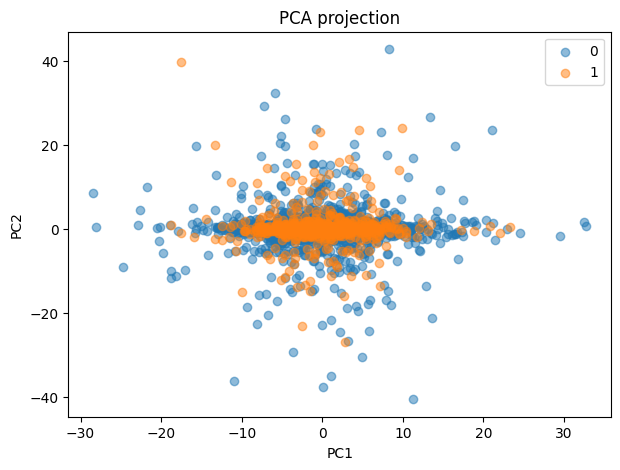

In [41]:
from sklearn.decomposition import PCA

X = ch1[feature_cols].values
y = ch1["label"].values

pca = PCA(n_components=2500)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(7,5))
for label in np.unique(y):
    plt.scatter(X_pca[y == label, 0], X_pca[y == label, 1], label=label, alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA projection")
plt.legend()
plt.show()

In [49]:
normal = X_pca[y == 0]
af = X_pca[y == 1]

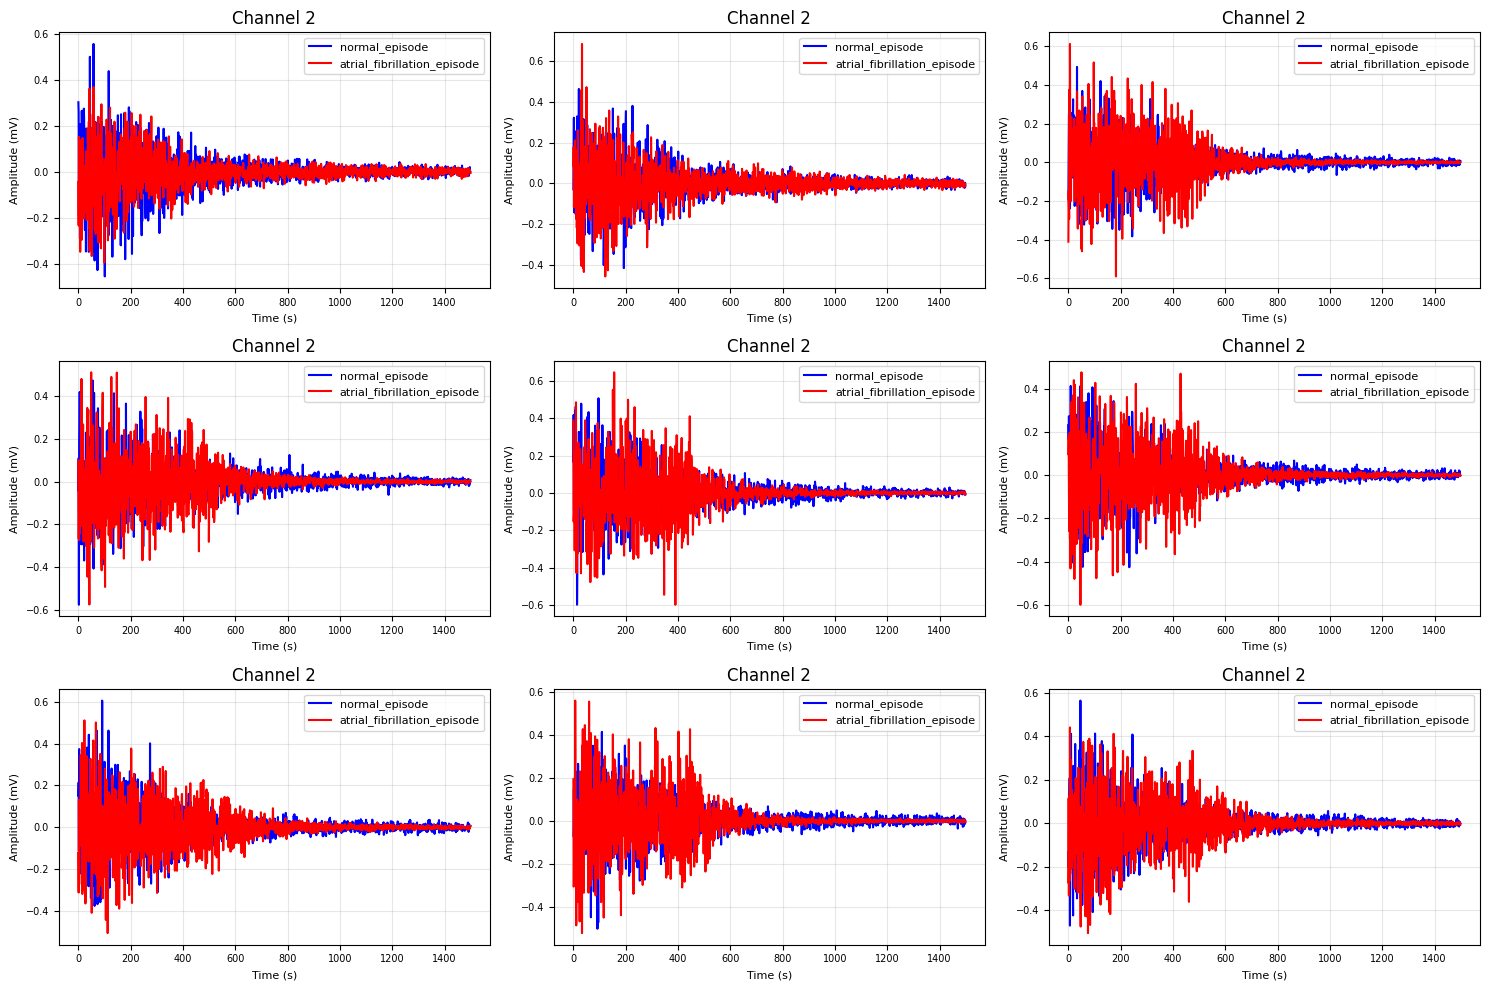

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

fig_index = 200
length = 1500
time_start = 500
time_end = time_start + length if (time_start + length) < 2500 else 2500
for i in range(3):
    for j in range(3):
        axes[i, j].plot(normal[fig_index, time_start:time_end], 'b-', label='N_episode')
        axes[i, j].plot(af[fig_index, time_start:time_end], 'r-', label='AF_episode')
        axes[i, j].set_title(f'Channel 2, After PCA')
        axes[i, j].grid(True)

        axes[i, j].set_xlabel('Time (s)', fontsize=8)
        axes[i, j].set_ylabel('Amplitude (mV)', fontsize=8)
        axes[i, j].grid(True, alpha=0.3)
        axes[i, j].legend(fontsize=8)
        axes[i, j].tick_params(labelsize=7)

        fig_index += 1

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

<h3> Filtering Data to remove noise </h3>

In [ ]:
from scipy.signal import butter, filtfilt, iirnotch

In [ ]:
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    fs = 250
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

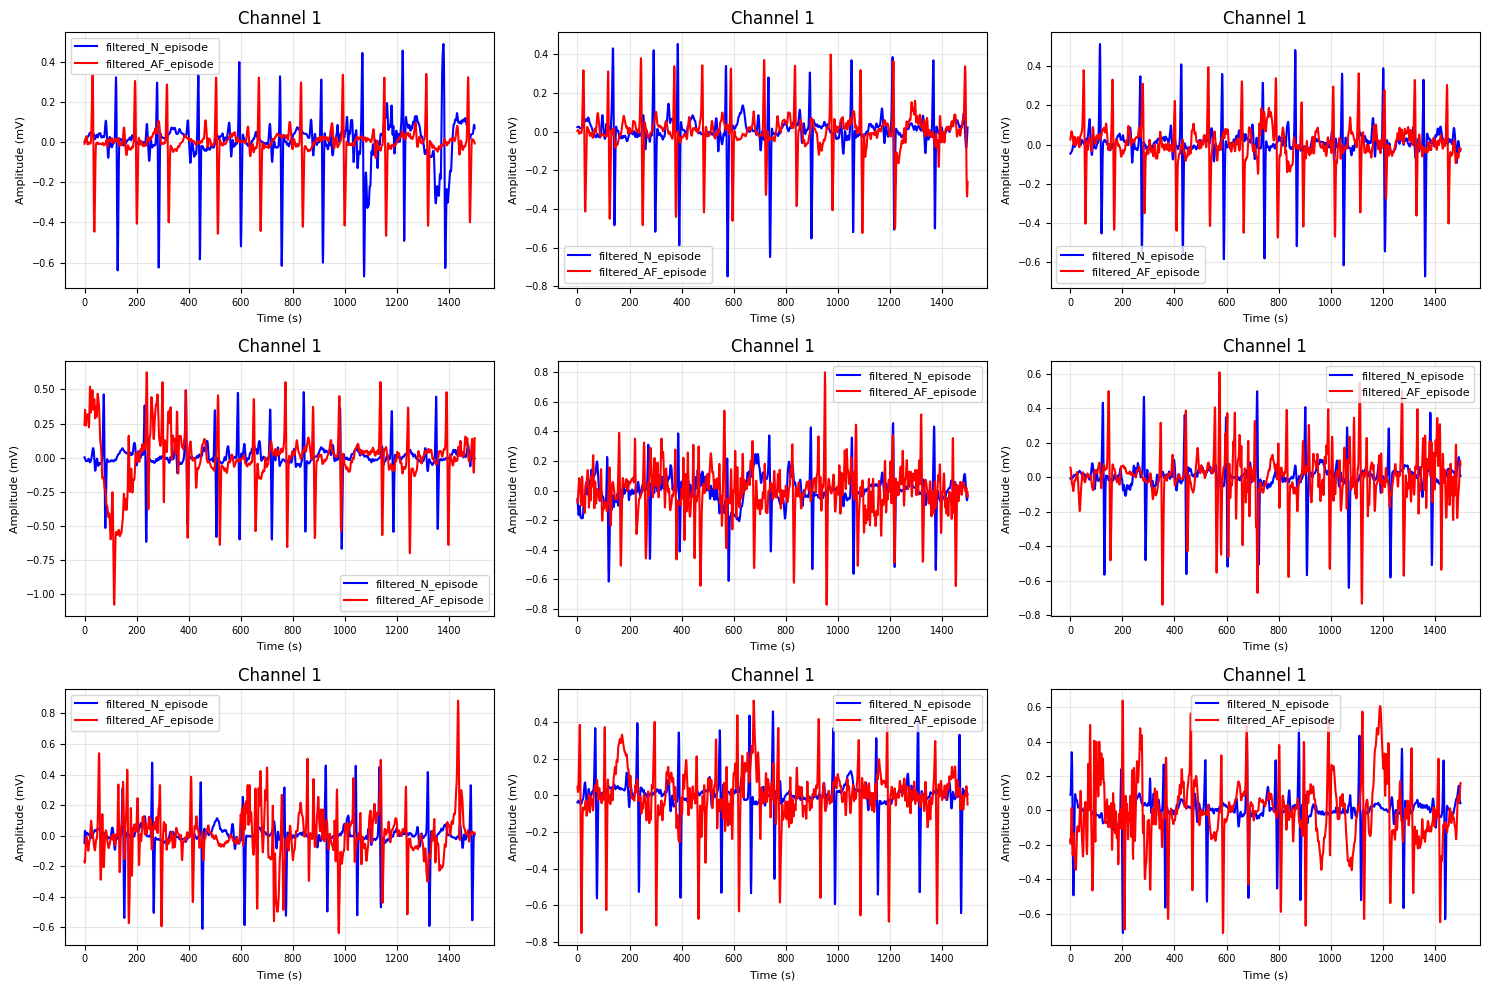

In [92]:
filtered_normal = bandpass_filter(normal, 0.5, 40, 250)
filtered_af = bandpass_filter(af, 0.5, 40, 250)

fig, axes = plt.subplots(3, 3, figsize=(15, 10))

fig_index = 200
length = 1500
time_start = 100
time_end = time_start + length if (time_start + length) < 2500 else 2500
for i in range(3):
    for j in range(3):
        axes[i, j].plot(filtered_normal[fig_index, time_start:time_end], 'b-', label='filtered_N_episode')
        axes[i, j].plot(filtered_af[fig_index, time_start:time_end], 'r-', label='filtered_AF_episode')
        axes[i, j].set_title(f'Channel 1')
        axes[i, j].grid(True)

        axes[i, j].set_xlabel('Time (s)', fontsize=8)
        axes[i, j].set_ylabel('Amplitude (mV)', fontsize=8)
        axes[i, j].grid(True, alpha=0.3)
        axes[i, j].legend(fontsize=8)
        axes[i, j].tick_params(labelsize=7)

        fig_index += 1

# Adjust spacing between subplots
plt.tight_layout()
plt.show()


<h2>Loading .Mat file </h2>

In [32]:
from scipy.io import loadmat

In [42]:
mat_file_path = 'D:/notebook/Deep Learning Course/Atrial-Fibrillation-Detection/data/A_0001_2.mat'
mat_data = loadmat(mat_file_path)

In [ ]:
mat_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'ECG_data', 'Radar_data'])

In [44]:
mat_data['Radar_data'].shape, mat_data['ECG_data'].shape

((1000, 3, 3), (1000, 1))

<h2>Frequency Domain Visualization </h2>

<h4> Single Channel ECG FFT </h4>

In [81]:
sample_ecg_data = x[0]
print(sample_ecg_data.shape)
print(sample_ecg_data)

ecg1 = sample_ecg_data[:, 0]
ecg2 = sample_ecg_data[:, 1]
print(ecg1.shape, ecg2.shape)

(2500, 2)
[[-0.01  -0.16 ]
 [ 0.    -0.16 ]
 [-0.015 -0.14 ]
 ...
 [-0.025 -0.365]
 [-0.01  -0.385]
 [-0.01  -0.385]]
(2500,) (2500,)


In [80]:
freq = np.fft.fftfreq(ecg1.shape[-1])
freq_data = np.fft.fft(ecg1)
print(f"Frequency : {freq}, \n")
print(f"Real part :{freq_data.real}")
print(f"imaginary part: {freq_data.imag}")

Frequency : [ 0.      0.0004  0.0008 ... -0.0012 -0.0008 -0.0004], 

Real part :[-51.965      -15.35126786   7.57582501 ...   7.27065658   7.57582501
 -15.35126786]
imaginary part: [  0.          -3.48109832 -10.35921092 ...  10.95876901  10.35921092
   3.48109832]


In [ ]:
fft_mag = np.abs(freq_data)
fft_mag.shape, fft_mag

((2500,),
 array([51.965     , 15.74101237, 12.83379817, ..., 13.15131421,
        12.83379817, 15.74101237], shape=(2500,)))

Text(0.5, 1.0, 'Phase Value for lead I ecg')

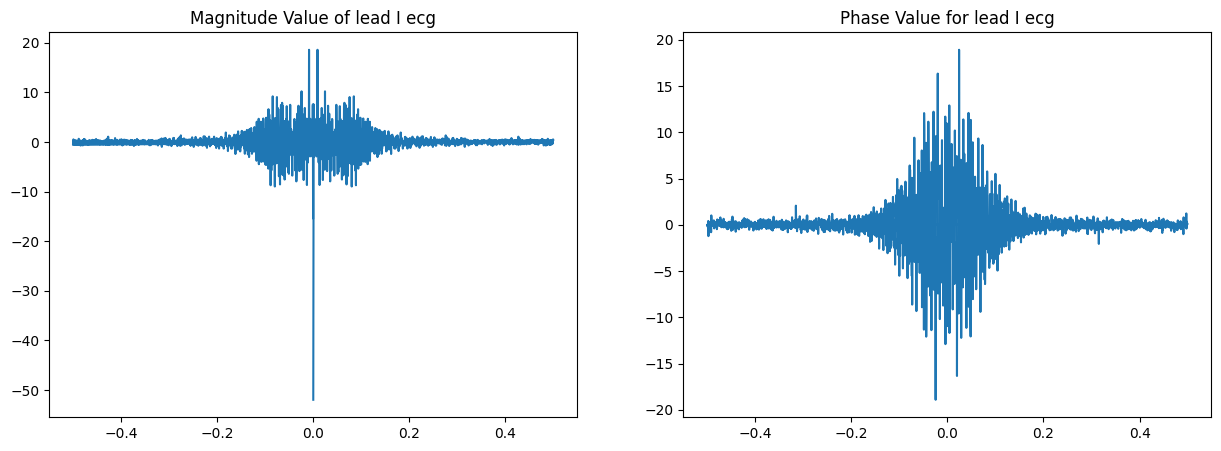

In [78]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(freq, freq_data.real)
plt.title('Magnitude Value of lead I ecg')

plt.subplot(1,2,2)
plt.plot(freq, freq_data.imag)
plt.title('Phase Value for lead I ecg')

<h4> Multi-channel Batch ECG FFT </h4>

In [85]:
batch_freq = np.fft.fftfreq(x.shape[1], 1/250)
batch_freq_data = np.fft.fft(x)

In [97]:
np.abs(batch_freq_data[0])

array([[0.17 , 0.15 ],
       [0.16 , 0.16 ],
       [0.155, 0.125],
       ...,
       [0.39 , 0.34 ],
       [0.395, 0.375],
       [0.395, 0.375]], shape=(2500, 2))

<h2> Model </h2>

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from copy import deepcopy

In [19]:
k1, p1 = 3, 1
k2, p2 = 5, 2
k3, p3 = 9, 4
k4, p4 = 17, 8
def my_permute(x, index): 
    y = x.reshape(x.shape[0], -1).detach().clone()  
    perm_index = torch.randperm(x.shape[0])
    for i in index:
        y[:, i] = y[perm_index, i]
    y = y.reshape(*x.size())  
    return y
def my_permute_new(x, index):
    y = deepcopy(x)
    perm_index = torch.randperm(x.shape[0])
    for i in index:
        y[:, i] = x[perm_index, i]
    return y
def my_freeze(x, index):  
    ori_size = x.size()
    x = x.reshape(x.shape[0], -1)
    x[:, index] = 0
    x = x.reshape(*ori_size)
    return x
def my_freeze_new(x, index): 
    y = x.clone()
    tmp_mean = x[:, index].mean(dim=0)
    y[:, index] = tmp_mean
    return y
def my_change(x, change_type, index):
    if change_type == 'permute':
        return my_permute_new(x, index)
    elif change_type == 'freeze':
        return my_freeze_new(x, index)
    else:
        raise ValueError("Undefined change_type")

In [20]:
class SELayer1D(nn.Module):
    def __init__(self, nChannels, reduction=16):
        super(SELayer1D, self).__init__()
        self.globalavgpool = nn.AdaptiveAvgPool1d(1)
        self.se_block = nn.Sequential(
            nn.Linear(nChannels, nChannels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(nChannels // reduction, nChannels, bias=False),
            nn.Sigmoid())
    def forward(self, x):
        alpha = torch.squeeze(self.globalavgpool(x))
        alpha = self.se_block(alpha)
        alpha = torch.unsqueeze(alpha, -1)
        out = torch.mul(x, alpha)
        return out
class BranchConv1D(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(BranchConv1D, self).__init__()
        C = out_channels // 4
        self.b1 = nn.Conv1d(in_channels, C, k1, stride, p1, bias=False)
        self.b2 = nn.Conv1d(in_channels, C, k2, stride, p2, bias=False)
        self.b3 = nn.Conv1d(in_channels, C, k3, stride, p3, bias=False)
        self.b4 = nn.Conv1d(in_channels, C, k4, stride, p4, bias=False)
    def forward(self, x):
        out = torch.cat([self.b1(x), self.b2(x), self.b3(x), self.b4(x)], dim=1)
        return out
class BasicBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, drop_out_rate, stride):
        super(BasicBlock1D, self).__init__()
        self.operation = nn.Sequential(
                BranchConv1D(in_channels, out_channels, stride),
                nn.BatchNorm1d(out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout(drop_out_rate),
                BranchConv1D(out_channels, out_channels, 1),
                nn.BatchNorm1d(out_channels),
                SELayer1D(out_channels))
        self.shortcut = nn.Sequential()
        if stride != 1:
            self.shortcut.add_module('MaxPool', nn.MaxPool1d(stride, ceil_mode=True))
        if in_channels != out_channels:
            self.shortcut.add_module('ShutConv', nn.Conv1d(in_channels, out_channels, 1))
            self.shortcut.add_module('ShutBN', nn.BatchNorm1d(out_channels))
    def forward(self, x):
        operation = self.operation(x)
        shortcut = self.shortcut(x)
        out = torch.relu(operation + shortcut)
        return out
class TEADNN(nn.Module):

    def __init__(self, num_classes=1, init_channels=1, growth_rate=16, base_channels=64,
                 stride=2, drop_out_rate=0.2):
        super(TEADNN, self).__init__()
        self.num_channels = init_channels
        block_n = 8
        block_c = [base_channels + i * growth_rate for i in range(block_n)]
        self.blocks = nn.Sequential()
        for i, C in enumerate(block_c):
            module = BasicBlock1D(self.num_channels, C, drop_out_rate, stride)
            self.blocks.add_module("block{}".format(i), module)
            self.num_channels = C
        module = nn.AdaptiveAvgPool1d(1)
        self.blocks.add_module("GlobalAvgPool", module)
        self.fc = nn.Linear(self.num_channels, num_classes)
    def get_feature_dim(self, place=None):
        feature_dim_list = [1 * 40 * 256, 32 * 128 * 126, 64 * 8 * 62, 128 * 7 * 14, 1024, 176, 1]
        return feature_dim_list[place] if place else feature_dim_list
    def forward(self, x, change_type=None, place=None, index=None):
        out = self.blocks(x)
        out1 = torch.squeeze(out)  
        if place == 5:
            out1 = my_change(out1, change_type, index)
        out2 = self.fc(out1)  
        return out2

In [23]:
init_channel = 2 if Config.channel == 2 else 1
model = TEADNN(num_classes=1, init_channels=init_channel)
model

TEADNN(
  (blocks): Sequential(
    (block0): BasicBlock1D(
      (operation): Sequential(
        (0): BranchConv1D(
          (b1): Conv1d(2, 16, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
          (b2): Conv1d(2, 16, kernel_size=(5,), stride=(2,), padding=(2,), bias=False)
          (b3): Conv1d(2, 16, kernel_size=(9,), stride=(2,), padding=(4,), bias=False)
          (b4): Conv1d(2, 16, kernel_size=(17,), stride=(2,), padding=(8,), bias=False)
        )
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Dropout(p=0.2, inplace=False)
        (4): BranchConv1D(
          (b1): Conv1d(64, 16, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (b2): Conv1d(64, 16, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
          (b3): Conv1d(64, 16, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
          (b4): Conv1d(64, 16, kernel_size=(17,), stride=(1,), p

In [ ]:
# dummmy_input = torch.rand(20, 2, 2500)
# dummy_gt = torch.rand(64, 1)
# model.eval()
# with torch.no_grad():
#     logits = model(dummmy_input)
# logits.shape

torch.Size([20, 1])

In [ ]:
# pred = torch.sigmoid(logits)
# pred = torch.where(pred > 0.5, 1, 0)
# pred

[np.int64(10),
 np.int64(20),
 np.int64(30),
 np.int64(10),
 np.int64(20),
 np.int64(30)]

<h3> DataLoader </h3>

In [24]:
from torch.utils.data import Dataset, DataLoader
from typing import List

In [25]:
class AFibDataset(Dataset):
    def __init__(self, path:str, file_names:List[str], window:int=2500, shift:int = 1250, channel:int = 2):
        self.path = path
        self.file_names = file_names
        self.window = window
        self.shift = shift
        self.channel = channel

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        x, y  = self.create_training_data(self.path, file_name, self.window, self.shift)
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.int8)

    def create_training_data(self, path:str, file_name:str, window:int, shift:int):
        record_name = os.path.join(path, file_name)
        signal = wfdb.rdrecord(record_name)
        ann = wfdb.rdann(record_name, 'atr')
        boundary_idx = 0
        start, next_boundary = ann.sample[boundary_idx], ann.sample[boundary_idx]
        region = ann.aux_note[boundary_idx]
        data = []
        label = []
        while start+window < signal.p_signal.shape[0]:
            if self.channel == 2:
                data.append(signal.p_signal[start:start+window, :])
            else:
                data.append(signal.p_signal[start:start+window, self.channel])
            if not start < next_boundary < start + window:
                label.append(0) if region == '(N' else label.append(1)
            else:
                percent = (next_boundary - start)/window * 100
                if percent > 50:
                    label.append(0) if region == '(N' else label.append(1)
                else:
                    label.append(1) if region == '(N' else label.append(0)
            start += shift
            if start > ann.sample[boundary_idx]:
                region = ann.aux_note[boundary_idx]
                if boundary_idx + 1 < len(ann.sample):
                    boundary_idx += 1
            next_boundary = ann.sample[boundary_idx]
        
        data = np.array(data)
        label = np.array(label)
        if data.ndim != 3:
            data = np.expand_dims(data, axis=-1)
        return data, label

In [ ]:
# dataset = AFibDataset(path, files, 2500, 1250, 1)
# dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [ ]:
# x, y = next(iter(dataloader))
# x = x.squeeze(dim=0).permute(0, 2, 1)
# y = y.squeeze(dim=0)
# x.shape, y.shape

(torch.Size([7363, 1, 2500]), torch.Size([7363]))

<h2> Training Part </h2>

In [2]:
import pytorch_lightning as pl
import torch.nn.functional as F
from torchmetrics.classification import BinaryAccuracy
from pytorch_lightning.callbacks import Callback, ModelCheckpoint
from sklearn.metrics import classification_report, precision_recall_fscore_support, roc_curve, auc
from sklearn.model_selection import train_test_split
import wandb
from io import BytesIO

In [ ]:
wandb.login(key='7bd60122a5756789b39039e92a54c5c4a3693eee')
wandb.init(
    project = 'Msc-DL Course',
    name = f"run {Config.run}",
    config = {
        'epochs':Config.epoch,
        'lr':Config.lr,
        'batch':Config.batch_size
    }
)

In [ ]:
class PrintCallback(Callback):
    def on_train_start(self, trainer, pl_module):
        print("Training started!")
    def on_train_end(self, trainer, pl_module):
        print("Training is done.")

checkpoint_callback = ModelCheckpoint(
    dirpath='/kaggle/working/model',
    filename=f"run 1 {{epoch}}-{{AF_recall:.2f}}",
    monitor='AF_recall',
    mode='max',
    save_top_k=1,
    save_last=True
)

In [ ]:
class AFibDataLoader(pl.LightningDataModule):
    def __init__(self, path, train_file, val_file, window, shift, channel):
        super().__init__()
        self.train_file = train_file
        self.val_file = val_file
        self.channel = channel

        self.path = path
        self.window = window
        self.shift = shift


    def setup(self, stage=None):
        if stage == 'fit':
            self.train_dataset = AFibDataset(self.path, self.train_file, self.window, self.shift, self.channel)
            self.val_dataset = AFibDataset(self.path, self.val_file, self.window, self.shift, self.channel)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=1, shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=1, shuffle=False, num_workers=2)

In [ ]:
class AFibClassifier(pl.LightningModule):
    def __init__(self, model, batch_size, threshold = 0.5, lr=1e-3):
        super().__init__()
        self.model = model
        self.batch_size = batch_size
        self.lr = lr
        self.automatic_optimization = False
        self.criterion = nn.BCEWithLogitsLoss()
        self.train_acc = BinaryAccuracy(threshold=threshold)
        self.val_acc = BinaryAccuracy(threshold=threshold)
        self.val_preds = []
        self.val_labels = []

    def forward(self, x):
        return self.model(x)
    
    def log_wandb(self, y_true, y_pred):
        tpr, fpr, _ = roc_curve(y_true, y_pred)
        roc_auc = auc(tpr, fpr)

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.title('Receiver Operating Characteristic (ROC)')
        plt.legend(loc="lower right")
        buf = BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        roc_image = Image.open(buf)
        plt.close()
        wandb.log({
            'run':Config.run,
            'epoch':self.current_epoch,
            'ROC_AUC':wandb.Image(roc_image)
        })
    
    def calculate_class_weight(self, label):
        neg_class = (label == 0).sum().float()
        pos_class = (label == 1).sum().float()
        positive_weight = neg_class / pos_class
        positive_weight = torch.tensor([positive_weight], dtype=torch.float32, device=self.device)
        return positive_weight

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.squeeze(dim=0).permute(0, 2, 1)
        y = y.squeeze(dim=0)

        pos_weight = self.calculate_class_weight(y)
        self.criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        optim = self.optimizers()
        Loss, Acc = 0.0, 0.0
        
        for X, Y in self.generator(x, y, self.batch_size):
            logits = self(X).squeeze(1)
            loss = self.criterion(logits, Y.float())

            self.manual_backward(loss)
            optim.step()
            optim.zero_grad()

            preds = torch.sigmoid(logits)
            acc = self.train_acc(preds, Y.int())

            Loss += loss.item()
            Acc += acc
        self.log("train_loss", Loss/self.batch_size)
        self.log("train_acc", Acc/self.batch_size)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = x.squeeze(dim=0).permute(0, 2, 1)
        y = y.squeeze(dim=0)
        Loss, Acc = 0.0, 0.0
        for X, Y in self.generator(x, y, self.batch_size):
            logits = self(X).squeeze(1)
            loss = self.criterion(logits, Y.float())
            preds = torch.sigmoid(logits)
            acc = self.train_acc(preds, Y.int())
            Loss += loss.item()
            Acc += acc

            preds = torch.where(preds>0.5, 1, 0)
            self.val_preds.extend(preds.detach().cpu().numpy())
            self.val_labels.extend(Y.detach().cpu().numpy())
        self.log("val_loss", Loss/self.batch_size)
        self.log("val_acc", Acc/self.batch_size)
    
    def on_train_epoch_end(self):
        avg_train_loss = self.trainer.callback_metrics['train_loss']
        avg_train_acc = self.trainer.callback_metrics['train_acc']
        print(f"Train Loss: {avg_train_loss:.4f}")
        

    def on_validation_epoch_end(self):
        avg_validation_loss = self.trainer.callback_metrics['val_loss']
        report = classification_report(np.array(self.val_labels), np.array(self.val_preds), target_names=["Non-AF", "AF"])
        precision, recall, f1, _ = precision_recall_fscore_support(np.array(self.val_labels), np.array(self.val_preds))
        self.log_dict({
            'N_precision':precision[0],
            'AF_precision':precision[1],
            'N_recall':recall[0],
            'AF_recall':recall[1],
            'N_f1':f1[0],
            'AF_f1':f1[1]
            })
        print(f"\nepoch: {self.current_epoch+1}")
        print("\nValidation Classification Report:\n", report)
        print(f"Valiadtion Loss : {avg_validation_loss:.4f}")
        self.log_wandb(self.val_labels, self.val_preds)
        self.val_labels = []
        self.val_preds = []
        

    def configure_optimizers(self):
        return {"optimizer":torch.optim.Adam(self.parameters(), lr=self.lr)}
    
    def generator(self, x, y, step):
        length = x.shape[0]
        start = 0
        while start < length:
            if start + step <= length:
                yield x[start:start + step], y[start:start + step]
            else:
                yield x[start:], y[start:]
                break
            start += step

In [ ]:

train_files, val_files = train_test_split(files, test_size=0.2, random_state=42, shuffle=True)
DATA_MODULE = AFibDataLoader(path, train_files, val_files, Config.window, Config.shift, Config.channel)
MODEL_MODULE = AFibClassifier(model, Config.batch_size, lr=Config.lr, threshold=Config.threshold)

In [39]:
trainer = pl.Trainer(
    accelerator='auto', max_epochs=Config.epoch,
    deterministic=True, callbacks=[PrintCallback()],
    limit_train_batches=5,
    limit_val_batches=5,
    num_sanity_val_steps=0
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [40]:
trainer.fit(MODEL_MODULE, DATA_MODULE)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | TEADNN            | 2.1 M  | train
1 | criterion | BCEWithLogitsLoss | 0      | train
2 | train_acc | BinaryAccuracy    | 0      | train
3 | val_acc   | BinaryAccuracy    | 0      | train
--------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.464     Total estimated model params size (MB)
223       Modules in train mode
0         Modules in eval mode
/mnt/storage2/arafat_shovon/deep_learning_project/deep_learning_course/af_env/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training started!
Epoch 0:  40%|████      | 2/5 [04:34<06:52,  0.01it/s, v_num=2]

: 

<h3> Checking Corrupted File </h3>

In [62]:
for file in files:
    record_name = os.path.join(path, file)
    hea_file = record_name + ".hea"
    dat_file = record_name + ".dat"
    atr_file = record_name + ".atr"

    if not os.path.exists(hea_file):
        raise FileNotFoundError(f"Missing header file: {hea_file}")
    if not os.path.exists(dat_file):
        raise FileNotFoundError(f"Missing data file: {dat_file}")
    if not os.path.exists(atr_file):
        raise FileNotFoundError(f"Missing annotation file: {atr_file}")

    try:
        signal = wfdb.rdrecord(record_name)
        ann = wfdb.rdann(record_name, 'atr')
    except Exception as e:
        raise RuntimeError(f"Failed to read record {record_name}: {e}")

In [16]:
!nvidia-smi

Sun Aug 10 10:28:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.169                Driver Version: 570.169        CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:01:00.0  On |                  Off |
|  0%   43C    P8             41W /  450W |    6391MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [10]:
labels = np.where(np.random.randn(100)>0.5, 1, 0)
preds = np.where(np.random.randn(100)>0.5, 1, 0)
labels, preds

(array([0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
        1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
        0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0]),
 array([0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
        1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]))

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc
precision, recall, f1, support = precision_recall_fscore_support(labels, preds)

In [ ]:
precision, recall, f1, support

(array([0.62686567, 0.42424242]),
 array([0.68852459, 0.35897436]),
 array([0.65625   , 0.38888889]),
 array([61, 39]))

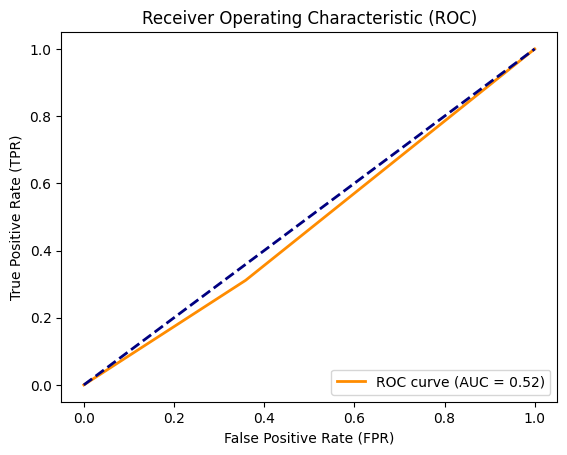

In [ ]:
tpr, fpr, thresh = roc_curve(labels, preds)
roc_auc = auc(tpr, fpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")


In [26]:
roc

0.5237494745691468